In [1]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import Align
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import re
import os
import copy
import pickle
import seaborn as sns
import gzip
import math
import networkx as nx
import matplotlib.pyplot as plt
import datetime
from itertools import combinations
date = datetime.datetime.now().strftime("%Y-%m-%d")
#from colorspacious import cspace_converter
#for statistics
import statistics
from scipy.stats import ttest_ind
from scipy.stats import chisquare
from scipy.stats import binomtest
from scipy.stats import ttest_rel
from scipy.stats import chi2_contingency, ttest_ind, levene, f, kruskal, chi2, linregress

In [3]:
def pickle_load(file):
    with gzip.open(file, 'rb') as f:
        print(f'file {file} loaded')
        gRNA_dict=pickle.load(f)
    return gRNA_dict    
#
def get_gRNA_info (txt,adjust=0): #build dictionary from gRNA_with_expression files
    with open(txt) as handle:
        keys=[x for x in next(handle).strip('\n').split(' ') if x !='']
        gRNA_dict={f'gRNA_{i}': {i:j for i,j in zip(keys,[x for x in line.strip('\n').split(' ') if x !=''][1:])}for i,line in enumerate(handle)}
        for key in gRNA_dict:
            init_site=int(gRNA_dict[key]['mRNA_end'])+int(gRNA_dict[key]['rel_pos'])
            if gRNA_dict[key]['mRNA_name'] not in ['CYB','MURF2']:
                gRNA_dict[key]['gene_mRNA_end']=init_site+adjust
            else:
                gRNA_dict[key]['gene_mRNA_end']=init_site
    return(gRNA_dict) 
def assign_gRNA_families(gRNA_dict,gfam,adjleft=2, adjright=3):
    for k in gRNA_dict:
        gRNA_dict[k]['gRNA_family']=[]
        hit=0
        product=gRNA_dict[k]['product']
        for gf,v in gfam.items():
            if v['mRNA']==gRNA_dict[k]['product']:
                bound=v['bound']
                if int(gRNA_dict[k]['gene_mRNA_end']) >= bound[0]-adjleft and int(gRNA_dict[k]['gene_mRNA_end']) <= bound[1]+adjright:
                    gRNA_dict[k]['gRNA_family'].append(gf)
                    gfam[gf]['gRNA'].append(k)
                    hit+=1
                    break
        if hit==0:
            print(f'error:cannot assign family for {k}')
    return(gRNA_dict,gfam)

In [4]:
Tb_pickle_updated='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/all_Tb_updated_4_dicts_0829.pickle'
gRNA_txt='/home/jovyan//Tbeqev/Infiles/OVI_gRNAs_2024-09-20.txt'
outdir='/home/jovyan//Tbeqev/Outfiles'
tmp=pickle_load(Tb_pickle_updated)
gRNA_dict,gRNA_families,mini_dict,renamed_mini_family=tmp[0],tmp[1],tmp[2],tmp[3]
gfam={gf:record for m,v in gRNA_families.items() for gf,record in v.items()}
gRNA_dict=get_gRNA_info(gRNA_txt)

file /home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/all_Tb_updated_4_dicts_0829.pickle loaded


In [5]:
#empty gfam:
for gf,v in gfam.items():
    gfam[gf]['gRNA']=[]
    gfam[gf]['minicircle_family']=[]
    gfam[gf]['cassettes']=[]
gRNA_dict,gfam=assign_gRNA_families(gRNA_dict,gfam,adjleft=2, adjright=3)

In [6]:
gfamovi={k:v for k,v in gfam.items() if v['gRNA']!=[]}

In [7]:
mrnagfamt={k:[gf for gf,v in gfamovi.items() if v['mRNA']==k] for k in gRNA_families}
mrnacount={k:len(v) for k,v in mrnagfamt.items()}
df=pd.DataFrame.from_dict(mrnacount,orient='index')
df.to_csv(f"{outdir}/gfam_counts.csv")

In [8]:
#on the same minicircle: COX3 and A6, RPS12
minicircles=set([v['mO_name'] for g,v in gRNA_dict.items()])
minicircles={m:[ v['product'] for g,v in gRNA_dict.items() if v['mO_name']==m] for m in minicircles}
#if most COX3 gRNAs are with A6
all_cox3=[k for k,v in minicircles.items() if 'COX3' in v]
cox3anda6=[k for k,v in minicircles.items() if 'COX3' in v and ('A6' in v or 'RPS12' in v)]

print(len(all_cox3),len(cox3anda6))

24 14


In [9]:
def assign_gRNA_fam_to_mini(gRNA_dict,gRNA_families): #use the new version
    mini_dict,cassettes,non_cannonical={},['I','II','III','IV','V','Orphan'],[]
    for g in gRNA_dict:
        if  'Maxi' not in gRNA_dict[g]['mO_name']:
            if gRNA_dict[g]['mO_name'] not in mini_dict:
                mini_dict[gRNA_dict[g]['mO_name']]={c:set() for c in cassettes}
                mini_dict[gRNA_dict[g]['mO_name']][gRNA_dict[g]['cassette_label']].add(g)
            else:
                mini_dict[gRNA_dict[g]['mO_name']][gRNA_dict[g]['cassette_label']].add(g)
    mini_dict.pop('Maxicircle','None') #remove maxicircle      
    mini_df = pd.DataFrame(columns=cassettes,index=mini_dict.keys())
    for mini in mini_dict:
        for c in mini_dict[mini]:
            try:
                mini_df.loc[[mini],[c]]=mini_dict[mini][c]['gRNA_family'][0]
            except:
                non_cannonical.append(f"no cannonical gRNA found in cassette {c} in minicircle {mini}")
    mini_df=mini_df.sort_values(by=cassettes)
    tmp={k:sum([1 for cs in v.values() if cs==set()]) for k,v in mini_dict.items()}
    tmp={k: v for k, v in sorted(tmp.items(), key=lambda item: item[1])}
    ordered=list(tmp.keys())
    mini_dict={k:mini_dict[k] for k in ordered}
    return(mini_dict,mini_df)
#group minicircles by gRNA family
def make_minicircle_family(mini_dict,gRNA_dict):
    mini_families={}
    for mini in mini_dict:
        #put gRNA family to cassettes
        hit=0
        mini_casettes={c: set([i for g in v for i in gRNA_dict[g]['gRNA_family']]) for c,v in mini_dict[mini].items()}
        if mini_families=={}:
            count=1
            mini_families[f"mf{count}"]={'cassettes': mini_casettes,'population':[mini]}
        else:
            for mf,records in mini_families.items():
                test=[0 if set(i) == set(j) else 1 for i,j in zip(mini_casettes.values(),mini_families[mf]['cassettes'].values())]
                if sum(test)==0:
                    mini_families[mf]['population'].append(mini)
                    hit+=1
                    break
            if hit==0: #if no matches were found
                count+=1
                mini_families[f"mf{count}"]={'cassettes': mini_casettes,'population':[mini]}
    #print(mini_families.keys())
    #sort by the number of encoded gRNAs
    tmp={k:sum([1 for cs in v['cassettes'].values() if cs==set()]) for k,v in mini_families.items()}
    tmp={k: v for k, v in sorted(tmp.items(), key=lambda item: item[1])}
    ordered=list(tmp.keys())
    mini_families={k:mini_families[k] for k in ordered}
    print(len(mini_families))
    return(mini_families)
def make_superfamilies_by_famiy(mini_families): #should give the same result by clustering class, need to do that 
    superf={}
    for mf,mfrecord in mini_families.items():
        #put gRNA family to cassettes
        hit=0
        if superf=={}:
            count=1
            superf[f"smf{count}"]={'cassettes': mini_families[mf]['cassettes'],'population':[mf]}
        else:
            for smf,smfrecord in superf.items():
                test=[0 if set(j).issubset(set(i)) else 1 
                      for i,j in zip(smfrecord['cassettes'].values(),mfrecord['cassettes'].values())]
                if sum(test)==0:
                    superf[smf]['population'].append(mf)
                    hit+=1
            if hit==0: #if no matches were found
                count+=1
                superf[f"smf{count}"]={'cassettes': mini_families[mf]['cassettes'],'population':[mf]}
    return(superf)
def make_superfamilies_by_class(mini_dict,gRNA_dict): #should give the same result by clustering class, need to do that 
    superf={}
    for mini in mini_dict:
        #put gRNA family to cassettes
        hit=0
        #mini_casettes={c: set([i for g in v for i in gRNA_dict[g]['gRNA_family']])
        mini_casettes={c: set([gRNA_dict[g]['gRNA_family'][0] for g in v])
                       for c,v in mini_dict[mini].items() if c in ['I','II','III','IV','V','Orphan']} #six positions, not just three
        if superf=={}:
            count=1
            superf[f"smf{count}"]={'cassettes': mini_casettes,'population':[mini]}
        else:
            for smf,smfrecord in superf.items():
                test=[0 if set(j).issubset(set(i)) else 1 
                      for i,j in zip(smfrecord['cassettes'].values(),mini_casettes.values())]
                if sum(test)==0:
                    superf[smf]['population'].append(mini)
                    hit+=1
            if hit==0: #if no matches were found
                count+=1
                superf[f"smf{count}"]={'cassettes': mini_casettes,'population':[mini]}
    return(superf)
#merge superfamilies (tie up loose ends)
def merge_superfamilies(superfam,intype):
    remove=[]
    for smf1,v1 in superfam.items():
        for smf2,v2 in superfam.items():
            if smf1 != smf2:
                test=[0 if c2.issubset(c1) else 1 for c1,c2 in zip(v1['cassettes'].values(),v2['cassettes'].values()) ]
                if sum(test)==0:
                    superfam[smf1]['population']=superfam[smf1]['population']+superfam[smf2]['population']
                    remove.append(smf2)
    superf={k:v for k,v in superfam.items() if k not in remove}
    print(len(superf))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3), sharey=False)
    #number of minicircle families
    data=[len(v['population']) for smf, v in superf.items()] #maxicircle gRNA
    bins=range(0,max(data)+2,1)
    counts, bins = np.histogram(data,bins=bins)
    print(counts)
    ax.hist(data,bins=bins)
    ax.set_xticks(bins)
    ax.set_ylabel('minicircle superfamily count')
    ax.set_xlabel(f'minicircle {intype} count')
    return(superf)
def gRNA_fam_per_superfamily(superf):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3), sharey=False)
    #number of minicircle families
    data=[sum([1 for k,c in v['cassettes'].items() if c!=set()]) for smf, v in superf.items()] #maxicircle gRNA
    bins=range(0,max(data)+2,1)
    counts, bins = np.histogram(data,bins=bins)
    print(counts)
    ax.hist(data,bins=bins)
    ax.set_xticks(bins)
    ax.set_ylabel('minicircle superfamily count')
    ax.set_xlabel(f'gRNA family count')


In [10]:
mini_cass,mini_df=assign_gRNA_fam_to_mini(gRNA_dict,gfamovi)
mini_families=make_minicircle_family(mini_cass,gRNA_dict)
mini_to_fam_dict={m:k for k,v in mini_families.items() for m in v['population']}

45


In [11]:
#reconstruct Tb mini families
def output_tb_mini_fam():
    tmp=pickle_load(Tb_pickle_updated)
    gRNA_dict,gRNA_families,mini_dict,renamed_mini_family=tmp[0],tmp[1],tmp[2],tmp[3]
    mini_cass,mini_df=assign_gRNA_fam_to_mini(gRNA_dict,gRNA_families)
    mini_families=make_minicircle_family(mini_cass,gRNA_dict)
    return (mini_families)

tbmf=output_tb_mini_fam()
tbmini_to_fam_dict={m:k for k,v in tbmf.items() for m in v['population']}

file /home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/all_Tb_updated_4_dicts_0829.pickle loaded
892


levene test for equal variances
taxon
T.b. brucei               4.7
T.b. gambiense type I     1.1
T.b. gambiense type II    4.5
T.b. rhodesiense          5.3
Name: OVI mf matches, dtype: float64
W = 56.01, p = 6.1e-27

T.b. rhodesiense: mean=19.87, st=5.31, max=27, sample size=23
T.b. brucei: mean=20.8, st=4.66, max=31, sample size=76
T.b. gambiense type II: mean=21.43, st=4.48, max=32, sample size=14
T.b. gambiense type I: mean=11.42, st=1.08, max=13, sample size=111
T.b. rhodesiense vs T.b. brucei 0.4178733388305861
T.b. rhodesiense vs T.b. gambiense type II 0.36585903783325224
T.b. rhodesiense vs T.b. gambiense type I 1.9516449224234473e-31
T.b. brucei vs T.b. gambiense type II 0.643811417300339
T.b. brucei vs T.b. gambiense type I 2.854738513372486e-49
T.b. gambiense type II vs T.b. gambiense type I 4.6709014954840756e-40


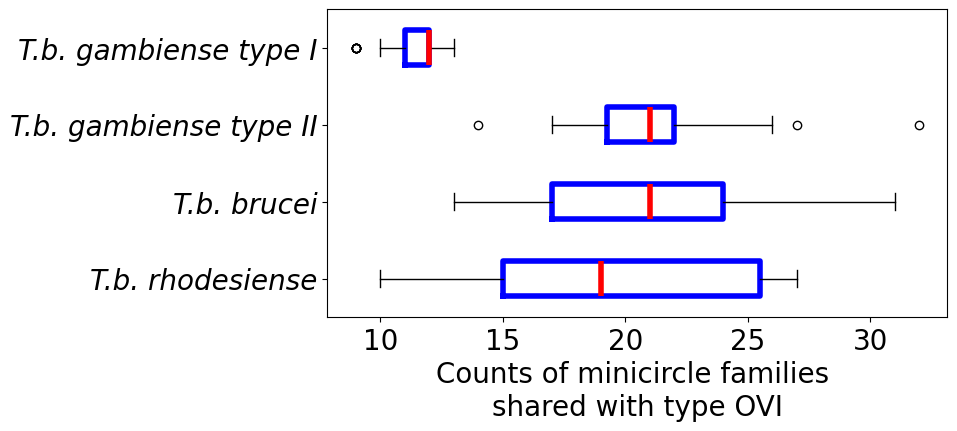

In [12]:
#compare ovi mf to tb mf
def compare_ovi_tb_mf(ovimfs,tbmfs):
    matches={}
    for mf1,v1 in ovimfs.items():
        matches[mf1]=[]
        for mf2,v2 in tbmfs.items():
            test1=[0 if c1.issubset(c2) else 1 for c1,c2 in zip(v1['cassettes'].values(),v2['cassettes'].values())]
            test2=[0 if c1==c2 else 1 for c1,c2 in zip(v1['cassettes'].values(),v2['cassettes'].values())]
            if sum(test2)==0:
                matches[mf1].append(mf2)
                #break
    return(matches)

def number_of_ovi_mf(matches,tb_mf_counts,feature):
    mfs=[v[0] for k,v in matches.items() if len(v)!=0]
    taxa=['T.b. rhodesiense','T.b. brucei','T.b. gambiense type II','T.b. gambiense type I']
    #data=[df[df['taxon']==t][mfs] for t in taxa]
    ovimatch=[]
    for i in tb_mf_counts.index:
        ovimatch.append(len(tb_mf_counts.loc[i][mfs][tb_mf_counts.loc[i][mfs].notna()]))
    tb_mf_counts['OVI mf matches']=ovimatch
    data=[tb_mf_counts[tb_mf_counts['taxon']==t][feature] for t in taxa]
    df=tb_mf_counts
    #
    #statistics
    print('levene test for equal variances')
    grouped = df.groupby(['taxon'])
    size_by_group = [g[feature].values for _, g in grouped]
    print(grouped[feature].std().round(1))
    statistic, pvalue = levene(*size_by_group, center='mean')
    #print(f'upper critical value of F_c=F_(0.05, {k-1}, {N-k}) = {f.ppf(1-0.05, k-1, N-k):.2f}')
    print(f'W = {statistic:.2f}, p = {pvalue:.2g}\n')
    for t in taxa:
        n=len(df[df['taxon']==t])
        mean=sum(df[df['taxon']==t][feature])/n
        st=round(statistics.stdev(df[df['taxon']==t][feature]),2)
        print(f"{t}: mean={round(mean,2)}, st={st}, max={max(df[df['taxon']==t][feature])}, sample size={n}")
    pairs=combinations(taxa, 2)
    for p in pairs:
        query=df[df['taxon']==p[0]][feature]
        subject=df[df['taxon']==p[1]][feature]
        a=ttest_ind(subject, query)
        if a.pvalue<1:
            print(f"{p[0]} vs {p[1]}",a.pvalue)
    #
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    ax.boxplot(data,labels=taxa,vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(taxa,style='italic')
    ax.set_xlabel(f'Counts of minicircle families \nshared with type OVI',fontsize=20)
    plt.show()


matches=compare_ovi_tb_mf(mini_families,tbmf)
nomatchdict={mini_families[mf]['population'][0]:mini_families[mf]['cassettes'] for mf in [k for k,v in matches.items() if len(v)==0]}
df=pd.DataFrame.from_dict(nomatchdict,orient='index')
df.to_csv(f"{outdir}/no_matches_mfs.csv") #output for making a table
#compare to tb
tb_mf_counts=pd.read_csv('/home/jovyan//Tbeqev/Infiles/Tb_mf_counts.csv',index_col=0)
number_of_ovi_mf(matches,tb_mf_counts,'OVI mf matches')

In [20]:
print({i[0]:1 for i in matches.values() if i!=[]})

{'mf30': 1, 'mf11': 1, 'mf126': 1, 'mf143': 1, 'mf205': 1, 'mf220': 1, 'mf204': 1, 'mf221': 1, 'mf160': 1, 'mf229': 1, 'mf277': 1, 'mf162': 1, 'mf145': 1, 'mf185': 1, 'mf170': 1, 'mf379': 1, 'mf306': 1, 'mf255': 1, 'mf149': 1, 'mf272': 1, 'mf429': 1, 'mf169': 1, 'mf173': 1, 'mf492': 1, 'mf653': 1, 'mf470': 1, 'mf536': 1, 'mf629': 1, 'mf532': 1, 'mf686': 1, 'mf527': 1, 'mf649': 1, 'mf710': 1, 'mf688': 1, 'mf660': 1, 'mf708': 1, 'mf486': 1, 'mf803': 1, 'mf872': 1, 'mf887': 1}


43
[ 0 41  2]
43
[ 0 41  2]
[ 0  3 16 22  2]


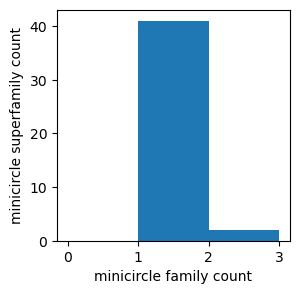

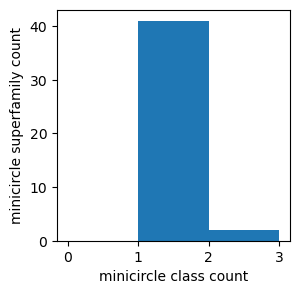

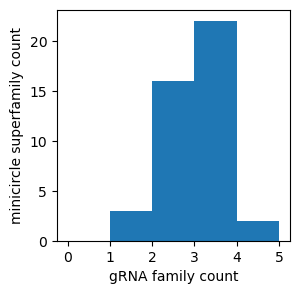

In [13]:
superfam1=make_superfamilies_by_famiy(mini_families)
superfam2=make_superfamilies_by_class(mini_cass,gRNA_dict)
superfam1=merge_superfamilies(superfam1,'family')
superfam2=merge_superfamilies(superfam2,'class')
gRNA_fam_per_superfamily(superfam1)